<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/IANNwTF_week6_Group40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2 Assignment: CIFAR-10 Classification**

---

In [ ]:
pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import datetime as datetime
import tqdm
import keras_cv

In [ ]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

In [ ]:
ds_info

In [ ]:
tfds.show_examples(train_ds, ds_info)

## **2.1 Prepare the dataset**

---

In [ ]:
def preprocess(ds):
    # image should be float
    ds = ds.map(lambda x, t: (tf.cast(x, tf.float32), t))
    # image vector will here have values between -1 and 1
    ds = ds.map(lambda x, t: ((x/128.)-1., t))
    # target vector is converted into one-hot vector
    ds = ds.map(lambda x, t: (x, tf.one_hot(t, depth=10))) 
    # cache
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)
     
    #Data Augmentation
    augmentation_model = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    )

    ds = ds.map(lambda x, y: (augmentation_model(x), y), num_parallel_calls = tf.data.AUTOTUNE)

    return ds    

train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

## **2.2 Optimise Your Model**

---
Model:
*   With L1
*   With L2
*   Dropout
*   Label smoothing
*   Batch normalization
*   Without any regularizers



In [ ]:
class Conv_Model(tf.keras.Model):
    def __init__(self, L1=0, L2=0, dropout_rate=0, loss_function=False, batch_norm=False):
        super(Conv_Model, self).__init__()

        self.metrics_list = [tf.keras.metrics.Mean(name="total_frobenius_norm"),
                             tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.CategoricalAccuracy(name="accuracy"),]
        self.dropout_rate = dropout_rate
        self.loss_function = loss_function
        self.optimizer = tf.keras.optimizers.Adam()
        
        if L2 >= 0:
            kernel_regularizer=tf.keras.regularizers.L2(L2)
        elif L1 > 0: 
            kernel_regularizer=tf.keras.regularizers.L2(L1)

        if self.dropout_rate:
            self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

        if self.loss_function:
            self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        else:
            self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

        if batch_norm:
            self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.GlobalAvgPool2D(),
                               tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]

        else:
            self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), 
                               tf.keras.layers.Conv2D(32, 3,activation="relu", kernel_regularizer=kernel_regularizer), 
                               tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), 
                               tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), 
                               tf.keras.layers.GlobalAvgPool2D(),
                               tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]

    def call(self, x, training=False):
        for layer in self.layer_list[:-1]:
            x = layer(x)
            if self.dropout_rate:
                x = self.dropout_layer(x, training)

        return self.layer_list[-1](x)

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    def frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm

    @tf.function
    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update the state of the metrics according to loss
        self.metrics[0].update_state(self.frobenius())
        self.metrics[1].update_state(loss)
        self.metrics[2].update_state(label, prediction)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        img, label = data

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction)

        # update the state of the metrics according to loss
        self.metrics[0].update_state(self.frobenius())
        self.metrics[1].update_state(loss)
        self.metrics[2].update_state(label, prediction)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

In [ ]:
def create_summary_writers(config_name):
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [ ]:
# initialize lists for later visualiztion
train_forbenius_norm = []
train_losses = []
train_accuracies = []
val_forbenius_norm = []
val_losses = []
val_accuracies = []

# initialize epochs and learning rate
epochs = 15
learning_rate = 0.01

In [ ]:
# initialize model with L1 regularizer
model = Conv_Model(L1=0.001, loss_function=True)

In [ ]:
# initialize model with L2 regularizer
model = Conv_Model(L2=0.001, loss_function=True)

In [ ]:
# initialize model with dropout
model = Conv_Model(dropout_rate=0.5, loss_function=True)

In [ ]:
# initialize model with label smoothing
model = Conv_Model(loss_function=False)

In [ ]:
# initialize model with batch normalization
model = Conv_Model(batch_norm=True)

In [ ]:
# initialize model without regularizers
model = Conv_Model()

## **2.3 Train the network**
---

In [ ]:
def training():
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {model.optimizer}")

        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        for (key, value) in metrics.items():
            if key == "total_frobenius_norm":
                train_forbenius_norm.append(value.numpy())
            elif key == "loss":
                train_losses.append(value.numpy())
            elif key == "accuracy":
                train_accuracies.append(value.numpy())

        # reset metric object
        model.reset_metrics()

        # evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)

        # log validation metrics
        with val_summary_writer.as_default():
            for metric in model.metrics:
                tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "total_frobenius_norm":
                val_forbenius_norm.append(value.numpy())
            elif key == "loss":
                val_losses.append(value.numpy())
            elif key == "accuracy":
                val_accuracies.append(value.numpy())

        # reset all metrics
        model.reset_metrics()

In [ ]:
training()

Epoch: 0, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:28<00:00, 10.55it/s]


['train_total_frobenius_norm: 27.23931312561035', 'train_loss: 2.1238958835601807', 'train_accuracy: 0.20701999962329865']
['val_total_frobenius_norm: 30.15519142150879', 'val_loss: 2.019671678543091', 'val_accuracy: 0.25380000472068787']
Epoch: 1, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.94it/s]


['train_total_frobenius_norm: 32.28423309326172', 'train_loss: 1.971914291381836', 'train_accuracy: 0.28700000047683716']
['val_total_frobenius_norm: 34.61240005493164', 'val_loss: 1.926834225654602', 'val_accuracy: 0.31929999589920044']
Epoch: 2, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.94it/s]


['train_total_frobenius_norm: 36.99781036376953', 'train_loss: 1.8996446132659912', 'train_accuracy: 0.3346799910068512']
['val_total_frobenius_norm: 39.367252349853516', 'val_loss: 1.854984164237976', 'val_accuracy: 0.36059999465942383']
Epoch: 3, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 41.61174011230469', 'train_loss: 1.8433382511138916', 'train_accuracy: 0.3691200017929077']
['val_total_frobenius_norm: 43.706275939941406', 'val_loss: 1.8193410634994507', 'val_accuracy: 0.38260000944137573']
Epoch: 4, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 45.626495361328125', 'train_loss: 1.800682544708252', 'train_accuracy: 0.39041998982429504']
['val_total_frobenius_norm: 47.558528900146484', 'val_loss: 1.7894127368927002', 'val_accuracy: 0.40230000019073486']
Epoch: 5, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.94it/s]


['train_total_frobenius_norm: 49.31460952758789', 'train_loss: 1.7730824947357178', 'train_accuracy: 0.4080199897289276']
['val_total_frobenius_norm: 51.001953125', 'val_loss: 1.744619369506836', 'val_accuracy: 0.4178999960422516']
Epoch: 6, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.94it/s]


['train_total_frobenius_norm: 52.64773941040039', 'train_loss: 1.7474925518035889', 'train_accuracy: 0.4198800027370453']
['val_total_frobenius_norm: 54.26264953613281', 'val_loss: 1.7719305753707886', 'val_accuracy: 0.4092000126838684']
Epoch: 7, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 55.88828659057617', 'train_loss: 1.7315983772277832', 'train_accuracy: 0.42706000804901123']
['val_total_frobenius_norm: 57.52907943725586', 'val_loss: 1.7731531858444214', 'val_accuracy: 0.4090999960899353']
Epoch: 8, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:05<00:00, 12.49it/s]


['train_total_frobenius_norm: 59.05134963989258', 'train_loss: 1.7126153707504272', 'train_accuracy: 0.43689998984336853']
['val_total_frobenius_norm: 60.60334014892578', 'val_loss: 1.713077187538147', 'val_accuracy: 0.4392000138759613']
Epoch: 9, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 61.999210357666016', 'train_loss: 1.6995078325271606', 'train_accuracy: 0.44457998871803284']
['val_total_frobenius_norm: 63.43865966796875', 'val_loss: 1.6827775239944458', 'val_accuracy: 0.45809999108314514']
Epoch: 10, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 64.81429290771484', 'train_loss: 1.681768536567688', 'train_accuracy: 0.45320001244544983']
['val_total_frobenius_norm: 66.28063201904297', 'val_loss: 1.6811749935150146', 'val_accuracy: 0.4523000121116638']
Epoch: 11, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 67.61622619628906', 'train_loss: 1.668562650680542', 'train_accuracy: 0.46066001057624817']
['val_total_frobenius_norm: 68.98614501953125', 'val_loss: 1.6505099534988403', 'val_accuracy: 0.4697999954223633']
Epoch: 12, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 70.33905792236328', 'train_loss: 1.65531587600708', 'train_accuracy: 0.46786001324653625']
['val_total_frobenius_norm: 71.60334777832031', 'val_loss: 1.6629823446273804', 'val_accuracy: 0.45350000262260437']
Epoch: 13, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 72.8695297241211', 'train_loss: 1.6452325582504272', 'train_accuracy: 0.47473999857902527']
['val_total_frobenius_norm: 74.08647155761719', 'val_loss: 1.6321948766708374', 'val_accuracy: 0.47679999470710754']
Epoch: 14, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f30ec9ac3d0>


100%|██████████| 1563/1563 [02:22<00:00, 10.95it/s]


['train_total_frobenius_norm: 75.30472564697266', 'train_loss: 1.6351337432861328', 'train_accuracy: 0.4790799915790558']
['val_total_frobenius_norm: 76.47868347167969', 'val_loss: 1.6497564315795898', 'val_accuracy: 0.47269999980926514']


## **2.4 Visualization**

---

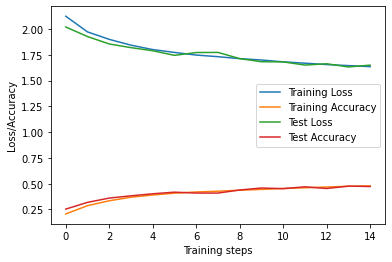

In [ ]:
fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(train_accuracies)
line3, = plt.plot(val_losses)
line4, = plt.plot(val_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4),("Training Loss","Training Accuracy","Test Loss","Test Accuracy"))
plt.show()

Observation:

---


Although the accuarcy decreases but the overfitting problem is solved.